In [31]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from matplotlib.lines import Line2D

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.lenses import lens_util
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [32]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_dev')

In [33]:
pprint(sorted(glob(os.path.join(ps_dir, 'im_subs_*_00000000.npy')))[:4])

['/data/bwedig/mejiro/output/power_spectra_dev/im_subs_cut_6_00000000.npy',
 '/data/bwedig/mejiro/output/power_spectra_dev/im_subs_cut_7_00000000.npy',
 '/data/bwedig/mejiro/output/power_spectra_dev/im_subs_cut_8_00000000.npy',
 '/data/bwedig/mejiro/output/power_spectra_dev/im_subs_no_subhalos_00000000.npy']


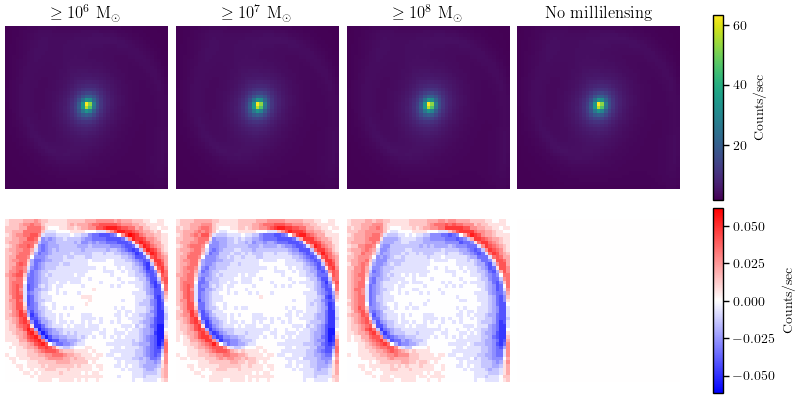

In [34]:
id = np.random.randint(0, 20)
uid = str(id).zfill(8)

images = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'im_subs_*_{uid}.npy')))]
# kappa_images = [np.load(i) for i in glob(os.path.join(ps_dir, 'kappa_im_*.npy'))]

r = np.load(os.path.join(ps_dir, 'r.npy'))
# kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))

f, ax = plt.subplots(2, 4, figsize=(8, 4), constrained_layout=True)

res_array = [images[3] - images[i] for i in range(4)]
v = plot_util.get_v(res_array)

for i in range(4):
    axis = ax[0][i].imshow(images[i])
    ax[0][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[0])
cbar.set_label('Counts/sec', rotation=90)

for i in range(4):
    axis = ax[1][i].imshow(images[3] - images[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[1])
cbar.set_label('Counts/sec', rotation=90)

ax[0][0].set_title('$\geq 10^6$ M$_\odot$')
ax[0][1].set_title('$\geq 10^7$ M$_\odot$')
ax[0][2].set_title('$\geq 10^8$ M$_\odot$')
ax[0][3].set_title('No millilensing')

plt.savefig(os.path.join(repo_dir, 'figures', 'artifacts.png'))
plt.show()

In [35]:
limit = 500

power_list_no_subhalos = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_no_subhalos_*.npy')))][:limit]
power_list_cut_6 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_6_*.npy')))][:limit]
power_list_cut_7 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_7_*.npy')))][:limit]
power_list_cut_8 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_8_*.npy')))][:limit]

stack_no_subhalos = np.vstack(power_list_no_subhalos)
stack_list_cut_6 = np.vstack(power_list_cut_6)
stack_list_cut_7 = np.vstack(power_list_cut_7)
stack_list_cut_8 = np.vstack(power_list_cut_8)

In [36]:
# power_list_no_subhalos_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_no_subhalos.npy'))]
# power_list_cut_6_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_6.npy'))]
# power_list_cut_7_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_7.npy'))]
# power_list_cut_8_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_8.npy'))]

# stack_no_subhalos_kappa = np.vstack(power_list_no_subhalos_kappa)
# stack_list_cut_6_kappa = np.vstack(power_list_cut_6_kappa)
# stack_list_cut_7_kappa = np.vstack(power_list_cut_7_kappa)
# stack_list_cut_8_kappa = np.vstack(power_list_cut_8_kappa)

In [37]:
# plt.plot(r, np.mean(stack_list_cut_8, axis=0), label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_7, axis=0), label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_6, axis=0), label='$\geq 10^6$ M$_\odot$')
# plt.plot(r, np.mean(stack_no_subhalos, axis=0), label='No subhalos')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [38]:
res_8 = np.mean(stack_list_cut_8, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_7 = np.mean(stack_list_cut_7, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_6 = np.mean(stack_list_cut_6, axis=0) - np.mean(stack_no_subhalos, axis=0)

# TODO fix
std_8 = np.std(stack_list_cut_8 - stack_no_subhalos, axis=0, ddof=1)
std_7 = np.std(stack_list_cut_7 - stack_no_subhalos, axis=0, ddof=1)
std_6 = np.std(stack_list_cut_6 - stack_no_subhalos, axis=0, ddof=1)

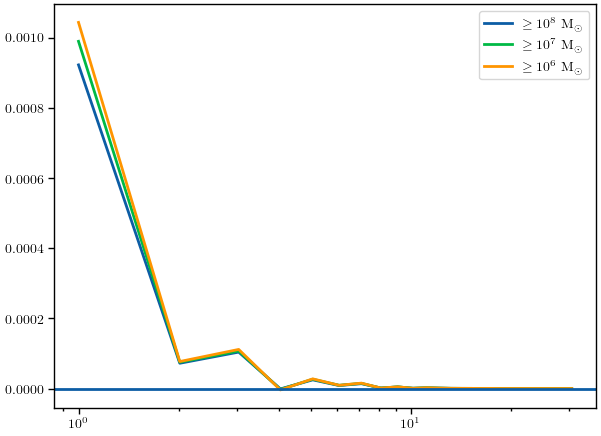

In [39]:
plt.plot(r, res_8, label='$\geq 10^8$ M$_\odot$')
# plt.fill_between(r, res_8 - std_8, res_8 + std_8, alpha=0.2)
plt.plot(r, res_7, label='$\geq 10^7$ M$_\odot$')
# plt.fill_between(r, res_7 - std_7, res_7 + std_7, alpha=0.2)
plt.plot(r, res_6, label='$\geq 10^6$ M$_\odot$')
# plt.fill_between(r, res_6 - std_6, res_6 + std_6, alpha=0.2)
# plt.plot(r, np.median(stack_list_cut_8 - stack_no_subhalos), axis=1)
plt.axhline(0)

# for i in range(2):
#     plt.plot(r, percentile_8[i], color='b', linestyle=':')
#     plt.plot(r, percentile_7[i], color='g', linestyle=':')
#     plt.plot(r, percentile_6[i], color='orange', linestyle=':')

plt.xscale('log')
plt.legend()
plt.show()

In [40]:
# res_8_kappa = np.mean(stack_list_cut_8_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
# res_7_kappa = np.mean(stack_list_cut_7_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
# res_6_kappa = np.mean(stack_list_cut_6_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)

In [41]:
# plt.plot(r, res_8_kappa, label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, res_6_kappa, label='$\geq 10^6$ M$_\odot$')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [42]:
power_list_nominal = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_4_*.npy')))][:limit]
power_list_1 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_1_*.npy')))][:limit]
power_list_9 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_9_*.npy')))][:limit]
power_list_17 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_17_*.npy')))][:limit]

stack_nominal = np.vstack(power_list_nominal)
stack_list_1 = np.vstack(power_list_1)
stack_list_9 = np.vstack(power_list_9)
stack_list_17 = np.vstack(power_list_17)

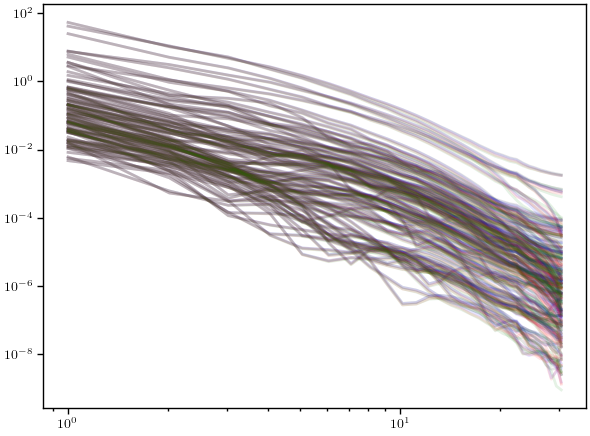

In [43]:
for ps in power_list_nominal:
    plt.loglog(r, ps, color='black', alpha=0.1)
for ps in power_list_1:
    plt.loglog(r, ps, color='blue', alpha=0.1)
for ps in power_list_9:
    plt.loglog(r, ps, color='red', alpha=0.1)
for ps in power_list_17:
    plt.loglog(r, ps, color='green', alpha=0.1)
plt.show()

In [44]:
dif_1 = np.mean(stack_list_1, axis=0) - np.mean(stack_nominal, axis=0)
dif_9 = np.mean(stack_list_9, axis=0) - np.mean(stack_nominal, axis=0)
dif_17 = np.mean(stack_list_17, axis=0) - np.mean(stack_nominal, axis=0)

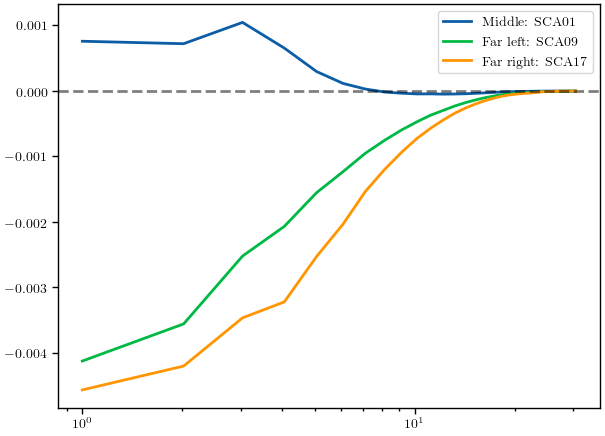

In [45]:
plt.plot(r, dif_1, label='Middle: SCA01')
plt.plot(r, dif_9, label='Far left: SCA09')
plt.plot(r, dif_17, label='Far right: SCA17')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.legend()
plt.show()

In [46]:
np.save(os.path.join(ps_dir, 'res_6'), res_6)
np.save(os.path.join(ps_dir, 'res_7'), res_7)
np.save(os.path.join(ps_dir, 'res_8'), res_8)
np.save(os.path.join(ps_dir, 'r.npy'), r)

In [47]:
res_6 = np.load(os.path.join(ps_dir, 'res_6.npy'))
res_7 = np.load(os.path.join(ps_dir, 'res_7.npy'))
res_8 = np.load(os.path.join(ps_dir, 'res_8.npy'))

In [48]:
cut_8_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_8.pkl')
cut_7_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_7.pkl')
cut_6_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_6.pkl')

In [49]:
num_lenses = 100
print(f'Collecting {num_lenses} lenses...')
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)[:num_lenses]
print(f'Collected {len(lens_list)} lens(es).')

Collected 100 lens(es).


In [50]:
lens = np.random.choice(lens_list)
print(f'Selected lens {lens.uid}')
lens._set_classes()

Selected lens 00000056


In [51]:
subhalo_params = {
    'r_tidal': 0.5,
    'sigma_sub': 0.055,
    'subhalo_cone': 5,
    'los_normalization': 0
}
imaging_params = {
    'bands': ['F106'],
    'oversample': 5,
    'num_pix': 45,
    'side': 4.95
}

r_tidal = subhalo_params['r_tidal']
sigma_sub = subhalo_params['sigma_sub']
subhalo_cone = subhalo_params['subhalo_cone']
los_normalization = subhalo_params['los_normalization']
bands = imaging_params['bands']
oversample = imaging_params['oversample']
num_pix = imaging_params['num_pix']
side = imaging_params['side']

In [52]:
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
log_m_host = np.log10(lens.main_halo_mass)

cut_8_good = False
i = 0

while not cut_8_good:
    realization = CDM(z_lens,
                z_source,
                sigma_sub=sigma_sub,
                log_mlow=6.,
                log_mhigh=10.,
                log_m_host=log_m_host,
                r_tidal=r_tidal,
                cone_opening_angle_arcsec=subhalo_cone,
                LOS_normalization=los_normalization)
    cut_8_good, halo = lens_util.check_halo_image_alignment(lens, realization, halo_mass=1e6, halo_sort_massive_first=False, return_halo=True)
    i += 1
print(f'Generated cut_8 population after {i} iterations.')

lens.kwargs_lens.append(halo.lenstronomy_params[0][0])
lens.lens_redshift_list += halo.z
lens.lens_model_list += halo.lenstronomy_ID

from lenstronomy.LensModel.lens_model import LensModel
lens.lens_model_class = LensModel(lens.lens_model_list)

Generated cut_8 population after 1 iterations.


In [53]:
with_subhalos = lens.get_array(45, 4.95, 'F106')

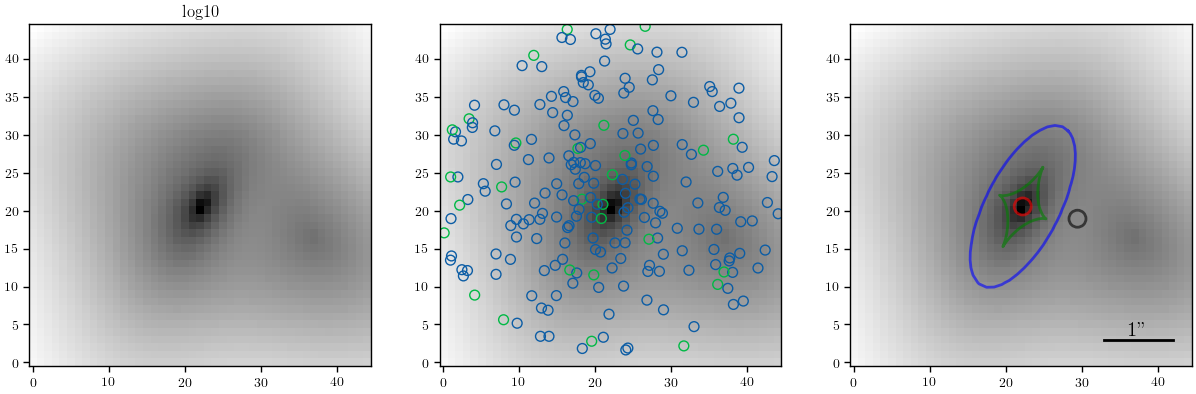

In [54]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(with_subhalos), cmap='binary')
ax[0].set_title('log10')
ax[1].imshow(np.log10(with_subhalos), cmap='binary')
ax[1].set_title('')

coords = lens_util.get_coords(45, delta_pix=0.11)

marker_size = 50

for halo in realization.halos:
    if halo.mass > 1e8:
        ax[1].scatter(*coords.map_coord2pix(halo.x, halo.y), s=marker_size, facecolors='none', edgecolors='#FF9500')
    elif halo.mass > 1e7:
        ax[1].scatter(*coords.map_coord2pix(halo.x, halo.y), s=marker_size, facecolors='none', edgecolors='#00B945')
    else:
        ax[1].scatter(*coords.map_coord2pix(halo.x, halo.y), s=marker_size, facecolors='none', edgecolors='#0C5DA5')

ax[2].imshow(np.log10(with_subhalos), cmap='binary')
overplot.source_position(ax[2], lens, coords, linewidth=2, alpha=0.6, color='black')
overplot.lens_position(ax[2], lens, coords, linewidth=2, alpha=0.6, color='red')
overplot.caustics(ax[2], lens, coords, num_pix, delta_pix=0.11, linewidth=2, alpha=0.6, color='g')
overplot.critical_curves(ax[2], lens, coords, num_pix, delta_pix=0.11, linewidth=2, alpha=0.6, color='b')

from lenstronomy.Plots import plot_util as len_plot_util
len_plot_util.scale_bar(ax[2], d=with_subhalos.shape[0], dist=1 / 0.11, text='1"', color='black', flipped=True)

plt.show()

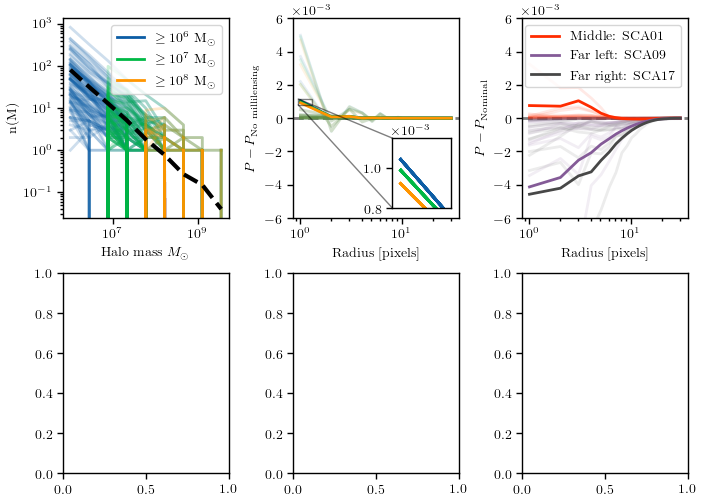

In [55]:
f, ax = plt.subplots(2, 3, figsize=(7, 5), constrained_layout=True)  # , sharey=True

limit = 15

cut_6_list = []
for realization in cut_6_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_6_list.append(N)
    ax[0][0].loglog(m[0:-1], N, alpha=0.2, color='#0C5DA5', label='$\geq 10^6$ M$_\odot$')
cut_7_list = []
for realization in cut_7_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_7_list.append(N)
    ax[0][0].loglog(m[0:-1], N, alpha=0.2, color='#00B945', label='$\geq 10^7$ M$_\odot$')
cut_8_list = []
for realization in cut_8_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_8_list.append(N)
    ax[0][0].loglog(m[0:-1], N, alpha=0.2, color='#FF9500', label='$\geq 10^8$ M$_\odot$')

m_mean = np.mean(cut_6_list, axis=0)
ax[0][0].loglog(m[0:-1], m_mean, color='black', linestyle='--', linewidth=3)

ax[0][0].set_xlabel('Halo mass '+r'$M_{\odot}$')
ax[0][0].set_ylabel('n(M)')
# ax[0][0].set_title('Subhalo mass functions')

custom_lines_1 = [Line2D([0], [0], color='#0C5DA5'),
                Line2D([0], [0], color='#00B945'),
                Line2D([0], [0], color='#FF9500')]

# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax[0][1].axhline(0, color='black', linestyle='--', alpha=0.5)

# for each in percentile_8:
#     ax[0].plot(r, each, color='purple', alpha=0.5, linestyle=':')

for i in range(limit):  #  + np.random.randint(0, 90)
    ax[0][1].plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
    ax[0][1].plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
    ax[0][1].plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='#FF9500')

ax[0][1].plot(r, res_6, color='#0C5DA5')
ax[0][1].plot(r, res_7, color='#00B945')
ax[0][1].plot(r, res_8, color='#FF9500')

ax[0][1].set_xscale('log')
ax[0][1].set_xlabel('Radius [pixels]')
ax[0][1].set_ylabel(r'$P - P_{\textrm{No millilensing}}$')
# ax[0].legend()
ax[0][0].legend(custom_lines_1, ['$\geq 10^6$ M$_\odot$', '$\geq 10^7$ M$_\odot$', '$\geq 10^8$ M$_\odot$'])
# ax[0][1].set_title('Varying subhalo populations')

x1, x2, y1, y2 = 0.95, 1.3, 8e-4, 1.15e-3
zoom_axes = ax[0][1].inset_axes(bounds=[0.6,0.05,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2))  # 
for i in range(limit):
    zoom_axes.plot(r, res_6, color='#0C5DA5')
    zoom_axes.plot(r, res_7, color='#00B945')
    zoom_axes.plot(r, res_8, color='#FF9500')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')
zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labeltop=False, labelleft=True, labelright=False)
zoom_axes.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0][1].indicate_inset_zoom(zoom_axes, edgecolor="black")

custom_lines_2 = [Line2D([0], [0], color='#FF2C00'),
                Line2D([0], [0], color='#845B97'),
                Line2D([0], [0], color='#474747')]

ax[0][2].axhline(0, color='black', linestyle='--', alpha=0.5)
for i in range(limit):
    ax[0][2].plot(r, [cut - none for cut, none in zip(power_list_1[i], power_list_nominal[i])], alpha=0.1, color='#FF2C00')
    ax[0][2].plot(r, [cut - none for cut, none in zip(power_list_9[i], power_list_nominal[i])], alpha=0.1, color='#845B97')
    ax[0][2].plot(r, [cut - none for cut, none in zip(power_list_17[i], power_list_nominal[i])], alpha=0.1, color='#474747')
ax[0][2].plot(r, dif_1, color='#FF2C00')
ax[0][2].plot(r, dif_9, color='#845B97')
ax[0][2].plot(r, dif_17, color='#474747')
ax[0][2].set_xscale('log')
ax[0][2].set_xlabel('Radius [pixels]')
ax[0][2].set_ylabel(r'$P - P_{\textrm{Nominal}}$')
# ax[1].legend()
ax[0][2].legend(custom_lines_2, ['Middle: SCA01', 'Far left: SCA09', 'Far right: SCA17'])
ax[0][2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[0][2].set_title('Varying focal plane position')

# ax[2].set_yticklabels([])
ax[0][1].sharey(ax[0][2])

# ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# ax[2].plot(kappa_r, res_8_kappa, label='$\geq 10^6$ M$_\odot$')
# ax[2].plot(kappa_r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# ax[2].plot(kappa_r, res_6_kappa, label='$\geq 10^8$ M$_\odot$')
# ax[2].set_xscale('log')
# ax[2].set_xlabel('Radius [pixels]')
# ax[2].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
# ax[2].legend()
# ax[2].set_title('Convergence maps')

ax[0][1].set_ylim([-6e-3, 6e-3])

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()

# TODO

## left

* select a suitable strong lens and show the image
* overplot halo positions with masses indicated by size (color?) of circles
>* blue for smallest ($10^6-10^7$)
>* green for middle ($10^7-10^8$)
>* yellow for largest ($>10^8$)
* draw caustics, etc.
* legend indicates caustics color code

## middle

* individual subhalo population power spectra
* band-dependence of power spectra (for $10^6-10^10$)
* PSF-dependence (for $10^6-10^10$)

## right

* 

In [56]:
# f, ax = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)  # , sharey=True

# limit = 15

# cut_6_list = []
# for realization in cut_6_realizations:
#     cdm_halo_masses = [halo.mass for halo in realization.halos]
#     N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
#     cut_6_list.append(N)
#     ax[0].loglog(m[0:-1], N, alpha=0.2, color='#0C5DA5', label='$\geq 10^6$ M$_\odot$')
# cut_7_list = []
# for realization in cut_7_realizations:
#     cdm_halo_masses = [halo.mass for halo in realization.halos]
#     N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
#     cut_7_list.append(N)
#     ax[0].loglog(m[0:-1], N, alpha=0.2, color='#00B945', label='$\geq 10^7$ M$_\odot$')
# cut_8_list = []
# for realization in cut_8_realizations:
#     cdm_halo_masses = [halo.mass for halo in realization.halos]
#     N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
#     cut_8_list.append(N)
#     ax[0].loglog(m[0:-1], N, alpha=0.2, color='#FF9500', label='$\geq 10^8$ M$_\odot$')

# m_mean = np.mean(cut_6_list, axis=0)
# ax[0].loglog(m[0:-1], m_mean, color='black', linestyle='--', linewidth=3)

# ax[0].set_xlabel('Halo mass '+r'$M_{\odot}$')
# ax[0].set_ylabel('n(M)')
# ax[0].set_title('Subhalo mass functions')

# from matplotlib.lines import Line2D
# custom_lines_1 = [Line2D([0], [0], color='#0C5DA5'),
#                 Line2D([0], [0], color='#00B945'),
#                 Line2D([0], [0], color='#FF9500')]

# # ax.plot(r, flat_ps, label='flat')
# # ax.plot(r, ps_no_subhalos, label='No subhalos')
# ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)

# # for each in percentile_8:
# #     ax[0].plot(r, each, color='purple', alpha=0.5, linestyle=':')

# for i in range(limit):  #  + np.random.randint(0, 90)
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
#     ax[1].plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='#FF9500')

# ax[1].plot(r, res_6, color='#0C5DA5')
# ax[1].plot(r, res_7, color='#00B945')
# ax[1].plot(r, res_8, color='#FF9500')

# ax[1].set_xscale('log')
# ax[1].set_xlabel('Radius [pixels]')
# ax[1].set_ylabel(r'$P - P_{\textrm{No millilensing}}$')
# # ax[0].legend()
# ax[0].legend(custom_lines_1, ['$\geq 10^6$ M$_\odot$', '$\geq 10^7$ M$_\odot$', '$\geq 10^8$ M$_\odot$'])
# ax[1].set_title('Varying subhalo populations')

# x1, x2, y1, y2 = 0.95, 1.3, 8e-4, 1.15e-3
# zoom_axes = ax[1].inset_axes(bounds=[0.6,0.05,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2))  # 
# for i in range(limit):
#     zoom_axes.plot(r, res_6, color='#0C5DA5')
#     zoom_axes.plot(r, res_7, color='#00B945')
#     zoom_axes.plot(r, res_8, color='#FF9500')
#     # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='#0C5DA5')
#     # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='#00B945')
#     # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')
# zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labeltop=False, labelleft=True, labelright=False)
# zoom_axes.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[1].indicate_inset_zoom(zoom_axes, edgecolor="black")

# custom_lines_2 = [Line2D([0], [0], color='#FF2C00'),
#                 Line2D([0], [0], color='#845B97'),
#                 Line2D([0], [0], color='#474747')]

# ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# for i in range(limit):
#     ax[2].plot(r, [cut - none for cut, none in zip(power_list_1[i], power_list_nominal[i])], alpha=0.1, color='#FF2C00')
#     ax[2].plot(r, [cut - none for cut, none in zip(power_list_9[i], power_list_nominal[i])], alpha=0.1, color='#845B97')
#     ax[2].plot(r, [cut - none for cut, none in zip(power_list_17[i], power_list_nominal[i])], alpha=0.1, color='#474747')
# ax[2].plot(r, dif_1, color='#FF2C00')
# ax[2].plot(r, dif_9, color='#845B97')
# ax[2].plot(r, dif_17, color='#474747')
# ax[2].set_xscale('log')
# ax[2].set_xlabel('Radius [pixels]')
# ax[2].set_ylabel(r'$P - P_{\textrm{Nominal}}$')
# # ax[1].legend()
# ax[2].legend(custom_lines_2, ['Middle: SCA01', 'Far left: SCA09', 'Far right: SCA17'])
# ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax[2].set_title('Varying focal plane position')

# # ax[2].set_yticklabels([])
# ax[1].sharey(ax[2])

# # ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# # ax[2].plot(kappa_r, res_8_kappa, label='$\geq 10^6$ M$_\odot$')
# # ax[2].plot(kappa_r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# # ax[2].plot(kappa_r, res_6_kappa, label='$\geq 10^8$ M$_\odot$')
# # ax[2].set_xscale('log')
# # ax[2].set_xlabel('Radius [pixels]')
# # ax[2].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
# # ax[2].legend()
# # ax[2].set_title('Convergence maps')

# ax[1].set_ylim([-6e-3, 6e-3])

# plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
# plt.show()

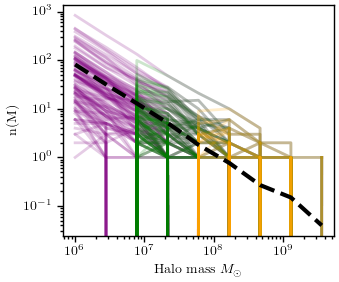

In [57]:
cut_8_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_8.pkl')
cut_7_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_7.pkl')
cut_6_realizations = util.unpickle_all(ps_dir, 'realization_', '_cut_6.pkl')

fig = plt.figure(1, figsize=(3.5, 3))
ax = plt.subplot(111)

cut_6_list = []
for realization in cut_6_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_6_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.2, color='purple')
cut_7_list = []
for realization in cut_7_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_7_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.2, color='green')
cut_8_list = []
for realization in cut_8_realizations:
    cdm_halo_masses = [halo.mass for halo in realization.halos]
    N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))
    cut_8_list.append(N)
    ax.loglog(m[0:-1], N, alpha=0.2, color='orange')

m_mean = np.mean(cut_6_list, axis=0)
ax.loglog(m[0:-1], m_mean, color='black', linestyle='--', linewidth=3)

ax.set_xlabel('Halo mass '+r'$M_{\odot}$')
ax.set_ylabel('n(M)')

plt.show()